## Importations de package

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from PIL import Image,ImageDraw
import skimage.morphology as morpho
from skimage.segmentation import watershed,mark_boundaries
import scipy.spatial as sp

## Gradient morphologique

Text(0.5, 1.0, 'Gradient morphologique')

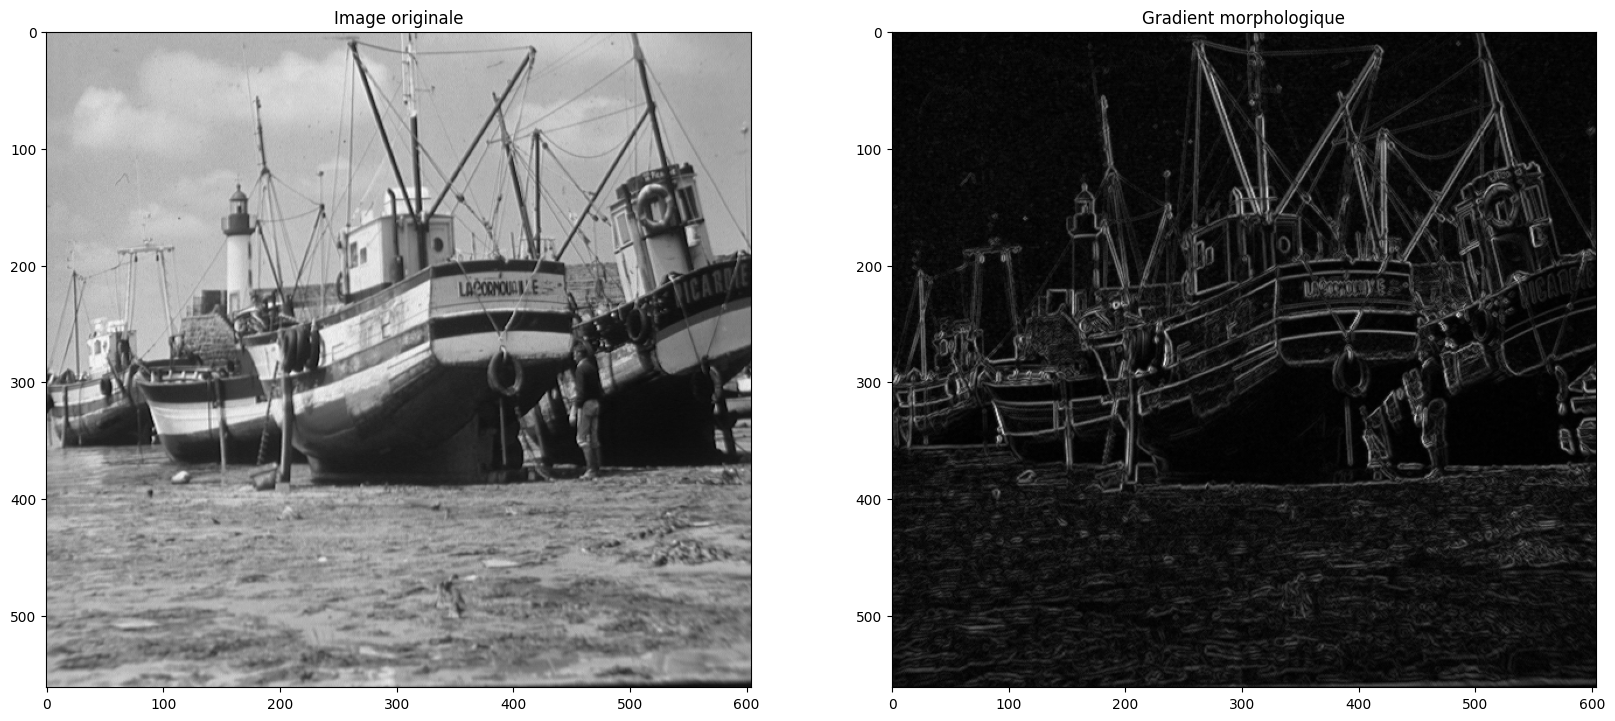

In [34]:
img = io.imread('images/bat.tif')



def gradmorpho(img):

    se = morpho.disk(1)
    morpho_grad = morpho.dilation(img,se) - morpho.erosion(img, se)

    return morpho_grad

grad_morpho = gradmorpho(img)

fig,ax = plt.subplots(1,2,figsize = (20,15))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image originale')
ax[1].imshow(grad_morpho,cmap = "gray")
ax[1].set_title('Gradient morphologique')


## Cellules hexagonales

In [8]:
def calcul_hexa_centers(img,taille):
    colonnes, lignes = img.size
    hexa_centers = []
    p_horizontal=3*taille*0.5
    p_vertical=np.sqrt(3)*taille
    I = int(colonnes/p_horizontal) + 2 #I est le nombre de centres par ligne
    J = int(lignes/p_vertical) + 2 #J est le nombre de centres par colonne
    for i in range(I):
        for j in range(J):
            if i%2==0:
                hexa_centers.append((int(i*p_horizontal) ,int(j*p_vertical)))
            else:
                hexa_centers.append((int(i*p_horizontal),int((j*p_vertical)+p_vertical/2)))
    return hexa_centers

"""
hexa_centers = calcul_hexa_centers(img,10)
lignes, colonnes = img.shape
img_test = np.zeros((lignes,colonnes))+255
for center in hexa_centers:
    #if center[0]<lignes and center[1]<colonnes:
    img_test[center[0]][center[1]] = 0
plt.imshow(img_test,cmap='gray')
print(hexa_centers)
#hexa_contours = np.zeros((lignes,colonnes,1))
"""


"\nhexa_centers = calcul_hexa_centers(img,10)\nlignes, colonnes = img.shape\nimg_test = np.zeros((lignes,colonnes))+255\nfor center in hexa_centers:\n    #if center[0]<lignes and center[1]<colonnes:\n    img_test[center[0]][center[1]] = 0\nplt.imshow(img_test,cmap='gray')\nprint(hexa_centers)\n#hexa_contours = np.zeros((lignes,colonnes,1))\n"

In [6]:
def hexa_sommets(centre, t, rho):
    x,y = centre
    taille= t*rho
    return [(x+taille,y),
            (x+(taille/2),y+(taille*np.sqrt(3)/2)),
            (x-(taille/2),y+(taille*np.sqrt(3)/2)),
            (x-taille,y),
            (x-(taille/2),y-(taille*np.sqrt(3)/2)),
            (x+(taille/2),y-(taille*np.sqrt(3)/2))
            ]


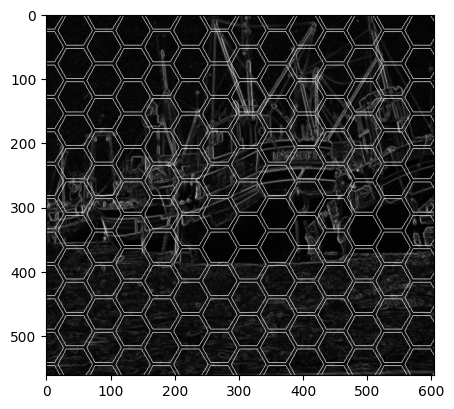

In [9]:
def hexagon(img, taille, rho):
    img_grid = img.copy()
    draw = ImageDraw.Draw(img_grid)
    hexa_centers = calcul_hexa_centers(img,taille)

    for c in hexa_centers:
        p = hexa_sommets(c, taille, rho)
        draw.polygon((p),outline="white")

    return img_grid

im = Image.fromarray(np.uint8(grad_morpho))
hexa = hexagon(im,30,0.9)
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(hexa, cmap='gray')


## Sélection des marqueurs

In [13]:
def point_dans_hexagon(centre,point,taille):
    x,y = point[0]-centre[0],point[1]-centre[1]
    distance = math.sqrt((x**2)+(y**2))
    if distance > 0:
        theta = math.acos(x/distance)
        theta = theta%(np.pi/3)
        distance_max=0
        if(theta<=np.pi/6):
            distance_max = taille*((((math.sqrt(3)*0.5)-1)*6*theta/np.pi)+1)
        else:
            distance_max = taille*(6*theta*(1-(math.sqrt(3)*0.5))/np.pi)+math.sqrt(3)-1
        return distance <= distance_max
    else:
        return True

In [11]:
def extract_hex_points(centre,taille):
    square = []
    hex=[]
    for x in range(-taille,taille):
        for y in range(-taille,taille):
            square.append((centre[0]+x,centre[1]+y))
    for s in square:
        if(point_dans_hexagon(centre,s,taille)):
            hex.append(s)
    return hex

In [100]:
def selection_marqueurs(im,taille):
    marqueurs = []
    for c in calcul_hexa_centers(im,taille):
        hex_points = extract_hex_points(c,taille)
        grad_hex = []
        grad_coord = []
        lignes, colonnes = im.size
        for p in hex_points:
            if (p[0]>=0 and p[0]<lignes and p[1]>=0 and p[1]<colonnes):
                grad_hex.append(im.getpixel((p[0],p[1])))
                grad_coord.append((p[0],p[1]))
        grad_hex = np.array(grad_hex)
        if len(grad_hex)>0:
            min_indices = np.where(grad_hex == grad_hex.min())[0]
            groupes_grad = [[i] for i in min_indices]
            for i1 in range(len(min_indices)):
                for i2 in range(len(min_indices)):
                    coord1 = grad_coord[min_indices[i1]]
                    coord2 = grad_coord[min_indices[i2]]
                    if coord1[0]==coord2[0]+1 or coord1[0]==coord2[0]-1 or coord1[0]==coord2[0]:
                        if coord1[1]==coord2[1]+1 or coord1[1]==coord2[1]-1 or coord1[1]==coord2[1]:
                            if min_indices[i2] not in groupes_grad[i1]:
                                groupes_grad[i1].append(min_indices[i2])
            groupe_grad_max = max([(i) for i in groupes_grad])
            position_marqueur = [(grad_coord[i]) for i in groupe_grad_max]
            marqueurs.append(position_marqueur)
        else:
            marqueurs.append([c])
    return marqueurs

selection_marqueurs(im,30)

[[(17, 3), (16, 3)],
 [(28, 55)],
 [(19, 101)],
 [(0, 151)],
 [(4, 203)],
 [(11, 235)],
 [(26, 314), (25, 313)],
 [(20, 352)],
 [(25, 410)],
 [(27, 465)],
 [(6, 521)],
 [(23, 561)],
 [(26, 25)],
 [(70, 77)],
 [(72, 134)],
 [(57, 179)],
 [(72, 236)],
 [(46, 295)],
 [(66, 348)],
 [(72, 385)],
 [(70, 451)],
 [(66, 490)],
 [(66, 552)],
 [(45, 597)],
 [(117, 6)],
 [(96, 48)],
 [(117, 104)],
 [(102, 161)],
 [(116, 206)],
 [(89, 260)],
 [(115, 309)],
 [(119, 364), (118, 363)],
 [(101, 421)],
 [(82, 460)],
 [(112, 513)],
 [(97, 558), (96, 558)],
 [(137, 42)],
 [(138, 70)],
 [(142, 143)],
 [(123, 191)],
 [(138, 209)],
 [(157, 285)],
 [(146, 362)],
 [(146, 363)],
 [(155, 442)],
 [(159, 495)],
 [(155, 555)],
 [(135, 597)],
 [(197, 3)],
 [(177, 46), (176, 47)],
 [(175, 101)],
 [(206, 151)],
 [(206, 210)],
 [(170, 245)],
 [(172, 300)],
 [(196, 361)],
 [(201, 424)],
 [(199, 476), (198, 475), (198, 476)],
 [(165, 497)],
 [(191, 551)],
 [(213, 41)],
 [(236, 82)],
 [(254, 131)],
 [(231, 203)],
 [(226, 